# Specular Model Tester

## For seeing if we really can map to the cubes. 

This notebook/program is intended to do the following: take in a VIMS image (with geo data) and compare it to the specular viewing geometry data from the specular simulation. The result should itself be two images: one with pixels ranked by the "scale" required to get the best match, and then by the quality of said best match. This should give a highly visual and intiutive way of telling if the model is working--all lakes should have good values, everything else should have easliy discernable worse values. 

First, though, we need to load in everything. This program requires a cube, a geo file for that cube, and the specular viewing gometry data. 

In [103]:
#IMPORTS 
import csv
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.misc
from scipy import ndimage

In [162]:
#READ-IN

#1) The Cube Itself.
cubeFilePath = r"C:\Users\deran\Desktop\CubeCSVDatabase\T104\CM_1787307197_1.cub.csv" #Kraken Mare

cubeFilePath = r"C:\Users\deran\Desktop\CubeCSVDatabase\T104\CM_1787307197_1.cub.csv"

#Now we extract the axes file as well...
cubeAxesfp = cubeFilePath.removesuffix(".csv") + ".axes.csv"

#and THIS time we also need the geofile! We only need the IR one, but we should read the others in just in case.

cubeGeofpVIS = cubeFilePath.removesuffix(".cub.csv") + "_ir_geo.cub.csv"
cubeGeofpIR = cubeFilePath.removesuffix(".cub.csv") + "_vis_geo.cub.csv"
cubeGeofpVISaxes = cubeFilePath.removesuffix(".cub.csv") + "_ir_geo.cub.axes.csv"
cubeGeofpIRaxes = cubeFilePath.removesuffix(".cub.csv") + "_vis_geo.cub.axes.csv"

#Load all the axes in. 
xAxisCube = []
yAxisCube = []
zAxisCube = []

xAxisGeoIR = []
yAxisGeoIR = []
zAxisGeoIR = []

xAxisGeoVIS = []
yAxisGeoVIS = []
zAxisGeoVIS = []

with open(cubeAxesfp) as csv_file: #remember to tab.
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        for row in csv_reader:
            i = 0
            L = len(row)
            while (i < L-1):
                if (line_count == 0):
                    xAxisCube.append(row[i])
                elif (line_count == 1):
                    yAxisCube.append(row[i])
                elif (line_count == 2):
                    zAxisCube.append(row[i])
                i = i+1
            line_count += 1
with open(cubeGeofpVISaxes) as csv_file: #remember to tab.
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        for row in csv_reader:
            i = 0
            L = len(row)
            while (i < L-1):
                if (line_count == 0):
                    xAxisGeoVIS.append(row[i])
                elif (line_count == 1):
                    yAxisGeoVIS.append(row[i])
                elif (line_count == 2):
                    zAxisGeoVIS.append(row[i])
                i = i+1
            line_count += 1
with open(cubeGeofpIRaxes) as csv_file: #remember to tab.
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        for row in csv_reader:
            i = 0
            L = len(row)
            while (i < L-1):
                if (line_count == 0):
                    xAxisGeoIR.append(row[i])
                elif (line_count == 1):
                    yAxisGeoIR.append(row[i])
                elif (line_count == 2):
                    zAxisGeoIR.append(row[i])
                i = i+1
            line_count += 1

#Now we need to substantiate the data holders for everything. 

cubeData = [[[0 for x in range(len(zAxisCube))] for x in range(len(yAxisCube))] for x in range(len(xAxisCube))]
geoVISData = [[[0 for x in range(len(zAxisGeoVIS))] for x in range(len(yAxisGeoVIS))] for x in range(len(xAxisGeoVIS))]
geoIRData = [[[0 for x in range(len(zAxisGeoIR))] for x in range(len(yAxisGeoIR))] for x in range(len(xAxisGeoIR))]

#The above holds the data of the cube itself. 

with open(cubeFilePath) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    i, j, k = 0, 0, 0
    for row in csv_reader:
        while (i < len(xAxisCube)):
            cubeData[i][j][k] = float(row[i])
            if (math.isnan(cubeData[i][j][k])):
                cubeData[i][j][k] = 0 #We set nans to zero to allow plotting to take place, careful!
            elif (cubeData[i][j][k] < 0):
                cubeData[i][j][k] = 0 #Negative values are nonsense.
            elif (cubeData[i][j][k] > 1):
                cubeData[i][j][k] = 1 #Make saturation obvious? Keep it from overloading. 
            i = i + 1
        i = 0
        j = j + 1
        if (j >= len(yAxisCube)):
            j = 0
            k = k + 1
        line_count += 1
with open(cubeGeofpVIS) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    i, j, k = 0, 0, 0
    for row in csv_reader:
        while (i < len(xAxisGeoVIS)):
            geoVISData[i][j][k] = float(row[i])
            if (math.isnan(geoVISData[i][j][k])):
                geoVISData[i][j][k] = 0 #We set nans to zero to allow plotting to take place, careful!
            i = i + 1
        i = 0
        j = j + 1
        if (j >= len(yAxisGeoVIS)):
            j = 0
            k = k + 1
        line_count += 1
with open(cubeGeofpIR) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    i, j, k = 0, 0, 0
    for row in csv_reader:
        while (i < len(xAxisGeoIR)):
            geoIRData[i][j][k] = float(row[i])
            if (math.isnan(geoIRData[i][j][k])):
                geoIRData[i][j][k] = 0 #We set nans to zero to allow plotting to take place, careful!
            i = i + 1
        i = 0
        j = j + 1
        if (j >= len(yAxisGeoIR)):
            j = 0
            k = k + 1
        line_count += 1

#That's the cube and geo data. 
#2) Now we have to load in the viewing geometry simulation data

X = 21
Y = 19
Z = 37
#These are hard coded as I know exactly what files these are.

dataWin1 = [[[0 for x in range(Z)] for x in range(Y)] for x in range(X)] 
dataWin2 = [[[0 for x in range(Z)] for x in range(Y)] for x in range(X)] 
dataWin3 = [[[0 for x in range(Z)] for x in range(Y)] for x in range(X)] 
dataWin4 = [[[0 for x in range(Z)] for x in range(Y)] for x in range(X)] 
dataWin5 = [[[0 for x in range(Z)] for x in range(Y)] for x in range(X)] 
dataWin6 = [[[0 for x in range(Z)] for x in range(Y)] for x in range(X)] 
dataWin7 = [[[0 for x in range(Z)] for x in range(Y)] for x in range(X)] 
dataWin8 = [[[0 for x in range(Z)] for x in range(Y)] for x in range(X)]

with open('iephi_consolidate_0.93w.txt') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    i, j, k = 0, 0, 0
    for row in csv_reader:
        while (i < X):
            dataWin1[i][j][k] = float(row[i])
            if (math.isnan(dataWin1[i][j][k])):
                dataWin1[i][j][k] = 0
            i = i + 1
        i = 0
        j = j + 1
        if (j >= Y):
            j = 0
            k = k + 1
        line_count += 1
with open('iephi_consolidate_1.08w.txt') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    i, j, k = 0, 0, 0
    for row in csv_reader:
        while (i < X):
            dataWin2[i][j][k] = float(row[i])
            if (math.isnan(dataWin2[i][j][k])):
                dataWin2[i][j][k] = 0
            i = i + 1
        i = 0
        j = j + 1
        if (j >= Y):
            j = 0
            k = k + 1
        line_count += 1
with open('iephi_consolidate_1.27w.txt') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    i, j, k = 0, 0, 0
    for row in csv_reader:
        while (i < X):
            dataWin3[i][j][k] = float(row[i])
            if (math.isnan(dataWin3[i][j][k])):
                dataWin3[i][j][k] = 0
            i = i + 1
        i = 0
        j = j + 1
        if (j >= Y):
            j = 0
            k = k + 1
        line_count += 1
with open('iephi_consolidate_1.59w.txt') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    i, j, k = 0, 0, 0
    for row in csv_reader:
        while (i < X):
            dataWin4[i][j][k] = float(row[i])
            if (math.isnan(dataWin4[i][j][k])):
                dataWin4[i][j][k] = 0
            i = i + 1
        i = 0
        j = j + 1
        if (j >= Y):
            j = 0
            k = k + 1
        line_count += 1
with open('iephi_consolidate_2.01w.txt') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    i, j, k = 0, 0, 0
    for row in csv_reader:
        while (i < X):
            dataWin5[i][j][k] = float(row[i])
            if (math.isnan(dataWin5[i][j][k])):
                dataWin5[i][j][k] = 0
            i = i + 1
        i = 0
        j = j + 1
        if (j >= Y):
            j = 0
            k = k + 1
        line_count += 1
with open('iephi_consolidate_2.69w.txt') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    i, j, k = 0, 0, 0
    for row in csv_reader:
        while (i < X):
            dataWin6[i][j][k] = float(row[i])
            if (math.isnan(dataWin6[i][j][k])):
                dataWin6[i][j][k] = 0
            i = i + 1
        i = 0
        j = j + 1
        if (j >= Y):
            j = 0
            k = k + 1
        line_count += 1
with open('iephi_consolidate_2.79w.txt') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    i, j, k = 0, 0, 0
    for row in csv_reader:
        while (i < X):
            dataWin7[i][j][k] = float(row[i])
            if (math.isnan(dataWin7[i][j][k])):
                dataWin7[i][j][k] = 0
            i = i + 1
        i = 0
        j = j + 1
        if (j >= Y):
            j = 0
            k = k + 1
        line_count += 1
with open('iephi_consolidate_5.00w.txt') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    i, j, k = 0, 0, 0
    for row in csv_reader:
        while (i < X):
            dataWin8[i][j][k] = float(row[i])
            if (math.isnan(dataWin8[i][j][k])):
                dataWin8[i][j][k] = 0
            i = i + 1
        i = 0
        j = j + 1
        if (j >= Y):
            j = 0
            k = k + 1
        line_count += 1
        
#Now do it again for the Lambertian files. 

dataWin1L = [[[0 for x in range(Z)] for x in range(Y)] for x in range(X)] 
dataWin2L = [[[0 for x in range(Z)] for x in range(Y)] for x in range(X)] 
dataWin3L = [[[0 for x in range(Z)] for x in range(Y)] for x in range(X)] 
dataWin4L = [[[0 for x in range(Z)] for x in range(Y)] for x in range(X)] 
dataWin5L = [[[0 for x in range(Z)] for x in range(Y)] for x in range(X)] 
dataWin6L = [[[0 for x in range(Z)] for x in range(Y)] for x in range(X)] 
dataWin7L = [[[0 for x in range(Z)] for x in range(Y)] for x in range(X)] 
dataWin8L = [[[0 for x in range(Z)] for x in range(Y)] for x in range(X)]

with open('iephi_consolidate_0.93wL.txt') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    i, j, k = 0, 0, 0
    for row in csv_reader:
        while (i < X):
            dataWin1L[i][j][k] = float(row[i])
            if (math.isnan(dataWin1L[i][j][k])):
                dataWin1L[i][j][k] = 0
            i = i + 1
        i = 0
        j = j + 1
        if (j >= Y):
            j = 0
            k = k + 1
        line_count += 1
with open('iephi_consolidate_1.08wL.txt') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    i, j, k = 0, 0, 0
    for row in csv_reader:
        while (i < X):
            dataWin2L[i][j][k] = float(row[i])
            if (math.isnan(dataWin2L[i][j][k])):
                dataWin2L[i][j][k] = 0
            i = i + 1
        i = 0
        j = j + 1
        if (j >= Y):
            j = 0
            k = k + 1
        line_count += 1
with open('iephi_consolidate_1.27wL.txt') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    i, j, k = 0, 0, 0
    for row in csv_reader:
        while (i < X):
            dataWin3L[i][j][k] = float(row[i])
            if (math.isnan(dataWin3L[i][j][k])):
                dataWin3L[i][j][k] = 0
            i = i + 1
        i = 0
        j = j + 1
        if (j >= Y):
            j = 0
            k = k + 1
        line_count += 1
with open('iephi_consolidate_1.59wL.txt') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    i, j, k = 0, 0, 0
    for row in csv_reader:
        while (i < X):
            dataWin4L[i][j][k] = float(row[i])
            if (math.isnan(dataWin4L[i][j][k])):
                dataWin4L[i][j][k] = 0
            i = i + 1
        i = 0
        j = j + 1
        if (j >= Y):
            j = 0
            k = k + 1
        line_count += 1
with open('iephi_consolidate_2.01wL.txt') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    i, j, k = 0, 0, 0
    for row in csv_reader:
        while (i < X):
            dataWin5L[i][j][k] = float(row[i])
            if (math.isnan(dataWin5L[i][j][k])):
                dataWin5L[i][j][k] = 0
            i = i + 1
        i = 0
        j = j + 1
        if (j >= Y):
            j = 0
            k = k + 1
        line_count += 1
with open('iephi_consolidate_2.69wL.txt') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    i, j, k = 0, 0, 0
    for row in csv_reader:
        while (i < X):
            dataWin6L[i][j][k] = float(row[i])
            if (math.isnan(dataWin6L[i][j][k])):
                dataWin6L[i][j][k] = 0
            i = i + 1
        i = 0
        j = j + 1
        if (j >= Y):
            j = 0
            k = k + 1
        line_count += 1
with open('iephi_consolidate_2.79wL.txt') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    i, j, k = 0, 0, 0
    for row in csv_reader:
        while (i < X):
            dataWin7L[i][j][k] = float(row[i])
            if (math.isnan(dataWin7L[i][j][k])):
                dataWin7L[i][j][k] = 0
            i = i + 1
        i = 0
        j = j + 1
        if (j >= Y):
            j = 0
            k = k + 1
        line_count += 1
with open('iephi_consolidate_5.00wL.txt') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    i, j, k = 0, 0, 0
    for row in csv_reader:
        while (i < X):
            dataWin8L[i][j][k] = float(row[i])
            if (math.isnan(dataWin8L[i][j][k])):
                dataWin8L[i][j][k] = 0
            i = i + 1
        i = 0
        j = j + 1
        if (j >= Y):
            j = 0
            k = k + 1
        line_count += 1

#Everything should be read in now. However we do need to scan the wavelength values of the windows.

windowum = [0.933078, 1.08183, 1.27813, 1.59018, 2.01781, 2.69620, 2.79889, 5.00576]
#Now we need to dynamically find the indeces where this is true. 
windowInd = [0,0,0,0,0,0,0,0]
i = 0
while (i < 8):
    j = 0
    while (j < len(zAxisCube)):
        if (float(zAxisCube[j]) < windowum[i] and float(zAxisCube[j+1]) > windowum[i]):
            if (windowum[i] - float(zAxisCube[j]) < float(zAxisCube[j+1]) - windowum[i]):
                windowInd[i] = j
                #Have to make sure we pick the closest point, not just the "lower" one.
            else:
                windowInd[i] = j+1
            j = len(zAxisCube)
        j = j + 1
    i = i+1
print(windowInd)
print(len(xAxisCube),len(yAxisCube))
print(len(cubeData), len(cubeData[0]), len(cubeData[0][0]))

[79, 107, 119, 138, 164, 205, 212, 343]
64 64
64 64 352


<IPython.core.display.Javascript object>


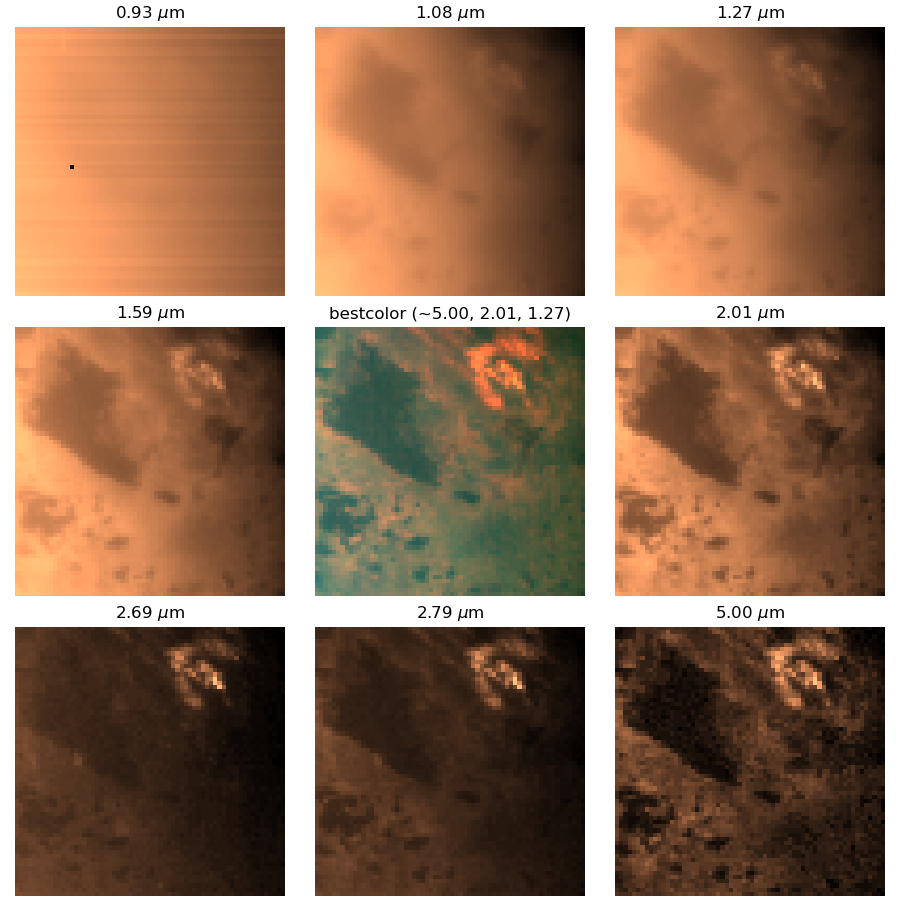

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [163]:
#DISPLAY: CUBE
#Just to show the cube we are reading in.
fig, axs = plt.subplots(3,3, figsize = (9,9), layout = "constrained") 

temp = np.transpose(cubeData)

#Windows are, according to lambertian_wholedisk:
#0.933078, 1.08183, 1.27813, 1.59018, 2.01781, 2.69620, 2.79889, 5.00576

c1 = axs[0,0].imshow((np.transpose(temp[windowInd[0]])), cmap="copper")
c2 = axs[0,1].imshow((np.transpose(temp[windowInd[1]])), cmap="copper")
c3 = axs[0,2].imshow((np.transpose(temp[windowInd[2]])), cmap="copper")
c4 = axs[1,0].imshow((np.transpose(temp[windowInd[3]])), cmap="copper")
c5 = axs[1,2].imshow((np.transpose(temp[windowInd[4]])), cmap="copper")
c6 = axs[2,0].imshow((np.transpose(temp[windowInd[5]])), cmap="copper")
c7 = axs[2,1].imshow((np.transpose(temp[windowInd[6]])), cmap="copper")
c8 = axs[2,2].imshow((np.transpose(temp[windowInd[7]])), cmap="copper")
#fig.colorbar(c4, ax=cax, label='High') 
#fig.tight_layout(pad=1.0)
axs[0,0].axis('off')
axs[0,1].axis('off')
axs[0,2].axis('off')
axs[1,0].axis('off')
axs[1,1].axis('off')
axs[1,2].axis('off')
axs[2,0].axis('off')
axs[2,1].axis('off')
axs[2,2].axis('off')
axs[1,1].axis('off')

#COLOR
#One of our colors is an average in titancolor2, so we need to grab it::
ave = (temp[336]+temp[337]+temp[338]+temp[339]+temp[340]+temp[341]
      +temp[342]+temp[343]+temp[344]+temp[345]+temp[346]+temp[347]
      +temp[348]+temp[349]+temp[350]+temp[351])/16.
mod = 1.

# set R, G, and B
R = np.transpose(ave/(mod*1.12/16.)) #Average dealing shenanigans.
G = np.transpose(temp[165]/(mod*0.22))
B = np.transpose((temp[120]-0.03)/(mod*0.37))
#B's value can introduce negatives, remove them.
i,j = 0,0
for x in B:
    j=0
    for y in x:
        if (y < 0):
            B[i][j] = 0
        j = j+1
    i = i+1

# Now we need to combine them in the correct form: xyc, that is, x, y, then color value. 
colorData = [R,G,B] # arranged in cyx.
colorData = np.transpose(colorData) #arranged in xyc
#This also introduces a rotation of the image by -90 degrees. 

image = axs[1,1].imshow(ndimage.rotate(colorData,90),origin="lower") 
#The rotation is undone here using rotate(). 

axs[0,0].set(title="0.93 $\mu$m")
axs[0,1].set(title="1.08 $\mu$m")
axs[0,2].set(title="1.27 $\mu$m")
axs[1,0].set(title="1.59 $\mu$m")
axs[1,1].set(title="bestcolor (~5.00, 2.01, 1.27)")
axs[1,2].set(title="2.01 $\mu$m")
axs[2,0].set(title="2.69 $\mu$m")
axs[2,1].set(title="2.79 $\mu$m")
axs[2,2].set(title="5.00 $\mu$m")

plt.show()

<IPython.core.display.Javascript object>


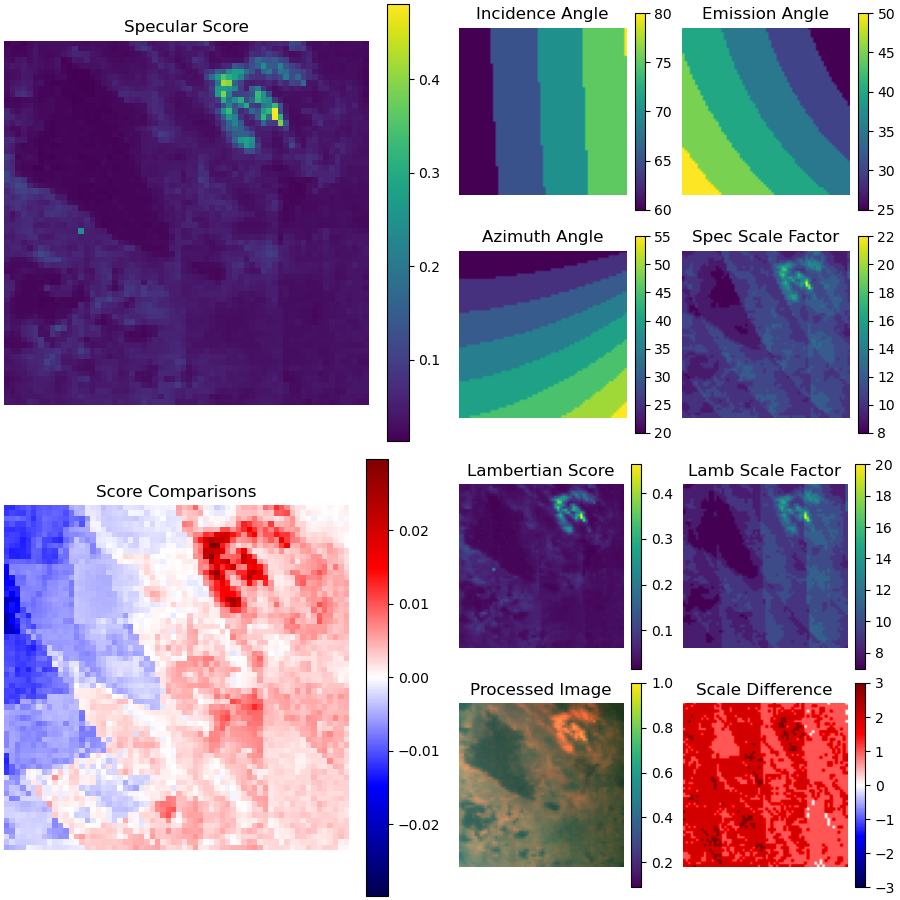

C:\Users\deran\AppData\Local\Temp\ipykernel_16180\2870096272.py:130: RuntimeWarning: divide by zero encountered in scalar divide
  tempScore = tempScore + ((pixelWindows[k]-geomWindows[k]*tempScale)
C:\Users\deran\AppData\Local\Temp\ipykernel_16180\2870096272.py:132: RuntimeWarning: divide by zero encountered in scalar divide
  tempScoreL = tempScoreL + ((pixelWindows[k]-geomWindowsL[k]*tempScale)
C:\Users\deran\AppData\Local\Temp\ipykernel_16180\2870096272.py:130: RuntimeWarning: invalid value encountered in scalar divide
  tempScore = tempScore + ((pixelWindows[k]-geomWindows[k]*tempScale)
C:\Users\deran\AppData\Local\Temp\ipykernel_16180\2870096272.py:132: RuntimeWarning: invalid value encountered in scalar divide
  tempScoreL = tempScoreL + ((pixelWindows[k]-geomWindowsL[k]*tempScale)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [171]:
%matplotlib notebook

method = "mul"

# "mul" multiplies everything by a scale factor for testing.
# "add" adds an offset to the data for testing.
# Both are chi-squared type tests. (Or will be)

#CREATE IMAGE!
#Goal: two images showcasing how close each pixel is to model. 

fig = plt.figure(figsize = (9,9), layout="constrained")

subfigs = fig.subfigures(2, 2, width_ratios=[1,1])

axA = subfigs[0][0].subplots()
axB = subfigs[1][0].subplots()
axC = subfigs[0][1].subplots(2,2)
axD = subfigs[1][1].subplots(2,2)

#First, the data our final image holds.
modelDiff = np.transpose(temp[0]*0.) #How far we have to shift
modelAcc = np.transpose(temp[0]*0.) #Value of best fit
modelDiffL = np.transpose(temp[0]*0.) #Lambertian versions of the above.
modelAccL = np.transpose(temp[0]*0.) 

angleI = np.transpose(temp[0]*0.)
angleA = np.transpose(temp[0]*0.)
angleE = np.transpose(temp[0]*0.)
#Transposed for a reason. "temp" is in wyx, and yx is not the arrangement we want for the image, we want xy.

#Up next is the bulk of the program, a massive loop that iterates over every single pixel 
#and records the appropriate values.
i,j = 0,0
while (i < len(xAxisCube)):
    j = 0
    while (j < len(yAxisCube)):
        #We have selected a pixel at this point.
        #First, grab the data for all 8 windows. Store it in an array.
        pixelWindows = [0.,0.,0.,0.,0.,0.,0.,0.]
        geomWindows = [0.,0.,0.,0.,0.,0.,0.,0.]
        geomWindowsL = [0.,0.,0.,0.,0.,0.,0.,0.]
        k = 0
        #print(i,j, len(xAxisCube), len(yAxisCube))
        while (k < 8):
            pixelWindows[k] = temp[windowInd[k]][j][i] #Backward since temp itself is in yx.
            k = k+1
        #Now we need to find the geometries for each pixel. Specifically:
        #incidence, emission, azimuth. 
        #These are contained within the geofiles.
        inci = geoIRData[i][j][5]
        emis = geoIRData[i][j][6]
        
        #Azimuth formula from Jason Barnes' phasecurve.c++
        p = geoIRData[i][j][4] #used to calculate azimuth.
        ratio = -(np.cos(np.radians(p)) - np.cos(np.radians(inci))* np.cos(np.radians(emis)))/(np.sin(np.radians(inci))*np.sin(np.radians(emis)))
        azim = np.arccos(ratio)
        #Of course, this might be nan-ing. All the nans need their own values.
        if((math.isnan(azim) == True) and (ratio>0.)):
            azim = 0.
        elif((math.isnan(azim) == True) and (ratio<0.)):
            azim = 0.
        elif((inci==0) and (emis==0)):
            azim = 0.
        elif(math.isnan(azim) == True):
            print("Well you broke it, great. (azimuth is nan, but could not be set to anything else)")
        
        #We are now armed with i, e, and phi(azimuth); in addition to the 8 wavelengths. 
        #Each pixel contains 11 pieces of information. 
        #Now we need to grab the comparison information from the viewing geometries.
        #The viewing geometries are in divisions of five degrees, so first all values need to be rounded.
        inci = round(inci/5)*5
        emis = round(emis/5)*5
        azim = round(np.degrees(azim)/5)*5
        #Sometimes data is corrupted or feeds us nonsense. We can force it to be reasonable. 
        if (inci < 0):
            inci = 0
        elif (inci > 100):
            inci = 100
        if (emis < 0):
            emis = 0
        elif (emis > 90):
            emis = 90
        if (azim < 0):
            azim = 0
        if (azim > 180):
            azim = 180
        
        #print(inci, emis, azim)
        
        geomWindows[0] = dataWin1[int(inci / 5)][int(emis / 5)][int(azim / 5)]
        geomWindows[1] = dataWin2[int(inci / 5)][int(emis / 5)][int(azim / 5)]
        geomWindows[2] = dataWin3[int(inci / 5)][int(emis / 5)][int(azim / 5)]
        geomWindows[3] = dataWin4[int(inci / 5)][int(emis / 5)][int(azim / 5)]
        geomWindows[4] = dataWin5[int(inci / 5)][int(emis / 5)][int(azim / 5)]
        geomWindows[5] = dataWin6[int(inci / 5)][int(emis / 5)][int(azim / 5)]
        geomWindows[6] = dataWin7[int(inci / 5)][int(emis / 5)][int(azim / 5)]
        geomWindows[7] = dataWin8[int(inci / 5)][int(emis / 5)][int(azim / 5)]            
        geomWindowsL[0] = dataWin1L[int(inci / 5)][int(emis / 5)][int(azim / 5)]
        geomWindowsL[1] = dataWin2L[int(inci / 5)][int(emis / 5)][int(azim / 5)]
        geomWindowsL[2] = dataWin3L[int(inci / 5)][int(emis / 5)][int(azim / 5)]
        geomWindowsL[3] = dataWin4L[int(inci / 5)][int(emis / 5)][int(azim / 5)]
        geomWindowsL[4] = dataWin5L[int(inci / 5)][int(emis / 5)][int(azim / 5)]
        geomWindowsL[5] = dataWin6L[int(inci / 5)][int(emis / 5)][int(azim / 5)]
        geomWindowsL[6] = dataWin7L[int(inci / 5)][int(emis / 5)][int(azim / 5)]
        geomWindowsL[7] = dataWin8L[int(inci / 5)][int(emis / 5)][int(azim / 5)]
        #Maybe should have made the viewing geometry data in one array... oh well.
        #Anyway, that's all the data we need. Now comes the actual processing steps!
        #First: determine a scaling factor that will minimize the differences across
        #all eight windows.
        scale = 0 #start at 0, work up to 10. This is decidedly overzealous.
        tempScale = 0 #For adjusting.
        score = 1000 #To determine which is the best. Absurdly large at the start.
        scoreL = 1000 #Lambertian as well.
        scaleL = 0
        
        floorVal = np.amin(geomWindows)  
        floorValL = np.amin(geomWindowsL)
        if (floorValL > floorVal):
            floorVal = floorVal
        #Get the smallest value so we can start at the lowest
        #offset when using the "add" method
        
        if (method == "mul"):
            while (tempScale <= 100):
                tempScore = 0
                tempScoreL = 0
                k = 0
                while (k < 8):
                    tempScore = tempScore + ((pixelWindows[k]-geomWindows[k]*tempScale)
                                             *(pixelWindows[k]-geomWindows[k]*tempScale))/(geomWindows[k]*tempScale)
                    tempScoreL = tempScoreL + ((pixelWindows[k]-geomWindowsL[k]*tempScale)
                                               *(pixelWindows[k]-geomWindowsL[k]*tempScale))/(geomWindowsL[k]*tempScale)
                    #The score is just the chi-squared number at whatever scale we're dealing with
                    k = k+1
                if (tempScore < score):
                    score = tempScore #Lower score is better!
                    scale = tempScale
                if (tempScoreL < scoreL):
                    scoreL = tempScoreL
                    scaleL = tempScale
                tempScale = tempScale + 1           
        elif (method == "add"):
            while (tempScale <= 1):
                tempScore = 0
                tempScoreL = 0
                k = 0
                while (k < 8):
                    tempScore = tempScore + ((pixelWindows[k]-geomWindows[k]-(tempScale-floorVal))
                                             *(pixelWindows[k]-geomWindows[k]-(tempScale-floorVal)))/(geomWindows[k]+(tempScale-floorVal))
                    tempScoreL = tempScoreL + ((pixelWindows[k]-geomWindowsL[k]-(tempScale-floorVal))
                                               *(pixelWindows[k]-geomWindowsL[k]-(tempScale-floorVal)))/(geomWindowsL[k]+(tempScale-floorVal))

                    tempScore = tempScore + abs(geomWindows[k]+(tempScale-floorVal) - pixelWindows[k])
                    tempScoreL = tempScoreL + abs(geomWindowsL[k]+(tempScale-floorVal) - pixelWindows[k])
                    #The score is very simple: simply add up the differences in all 8 points.
                    k = k+1
                #if (i == 1 and j == 1):
                    #print(tempScale, tempScore)
                if (tempScore < score):
                    score = tempScore #Lower score is better!
                    scale = tempScale
                if (tempScoreL < scoreL):
                    scoreL = tempScoreL
                    scaleL = tempScale
                tempScale = tempScale + 0.01
   
        modelDiff[i][j] = scale
        modelAcc[i][j] = score #Apparently it needs to flip here. 
        angleE[i][j] = emis
        angleI[i][j] = inci
        angleA[i][j] = azim
        
        modelDiffL[i][j] = scaleL
        modelAccL[i][j] = scoreL
        #There were some concerns that index flipping and transpositions might cause an
        #issue, but it appears to be fine either way. 
        #Even when the transpositions are done very badly it still works well enough.
        j=j+1
    i=i+1    

#Now, finally, display everything.

cmap = "viridis"

axA.set(title="Specular Score")
imgA = axA.imshow(modelAcc, cmap = cmap)
fig.colorbar(imgA, ax=axA)
axB.set(title="Score Comparisons")

#For any comparison with a middle, we need to set that middle.
diffDiff = modelDiff - modelDiffL
accDiff = modelAcc - modelAccL
maxi = np.amax(diffDiff)
mini = np.amin(diffDiff)
boundsD = 0
if (maxi > abs(mini)): 
    boundsD = maxi
else: boundsD = abs(mini)
maxi = np.amax(accDiff)
mini = np.amin(accDiff)
boundsA = 0
if (maxi > abs(mini)): 
    boundsA = maxi
else: boundsA = abs(mini)

imgB = axB.imshow(accDiff, cmap = "seismic", vmin = -boundsA, vmax = boundsA)
fig.colorbar(imgB, ax=axB)
axC[0][0].set(title="Incidence Angle")
axC[0][1].set(title="Emission Angle")
axC[1][0].set(title="Azimuth Angle")
axC[1][1].set(title="Spec Scale Factor")
imgC1 = axC[0][0].imshow(angleI, cmap = cmap)
imgC2 = axC[0][1].imshow(angleE, cmap = cmap)
imgC3 = axC[1][0].imshow(angleA, cmap = cmap)
imgC4 = axC[1][1].imshow(modelDiff, cmap = cmap)
fig.colorbar(imgC1, ax=axC[0][0])
fig.colorbar(imgC2, ax=axC[0][1])
fig.colorbar(imgC3, ax=axC[1][0])
fig.colorbar(imgC4, ax=axC[1][1])
axD[0][0].set(title="Lambertian Score")
axD[0][1].set(title="Lamb Scale Factor")
axD[1][0].set(title="Processed Image")
axD[1][1].set(title="Scale Difference")
imgD1 = axD[0][0].imshow(modelAccL, cmap = cmap)
imgD2 = axD[0][1].imshow(modelDiffL, cmap = cmap)
imgD3 = axD[1][0].imshow(ndimage.rotate(colorData,90), cmap = cmap, origin="lower")
imgD4 = axD[1][1].imshow(diffDiff, cmap = "seismic", vmin = -boundsD, vmax = boundsD)
fig.colorbar(imgD1, ax=axD[0][0])
fig.colorbar(imgD2, ax=axD[0][1])
fig.colorbar(imgD3, ax=axD[1][0])
fig.colorbar(imgD4, ax=axD[1][1])


axA.axis('off') #remove border and ticks. 
axC[0][0].axis('off')
axC[0][1].axis('off')
axC[1][0].axis('off')
axC[1][1].axis('off')
axB.axis('off') #remove border and ticks. 
axD[0][0].axis('off')
axD[0][1].axis('off')
axD[1][0].axis('off')
axD[1][1].axis('off')

plt.show()

<IPython.core.display.Javascript object>


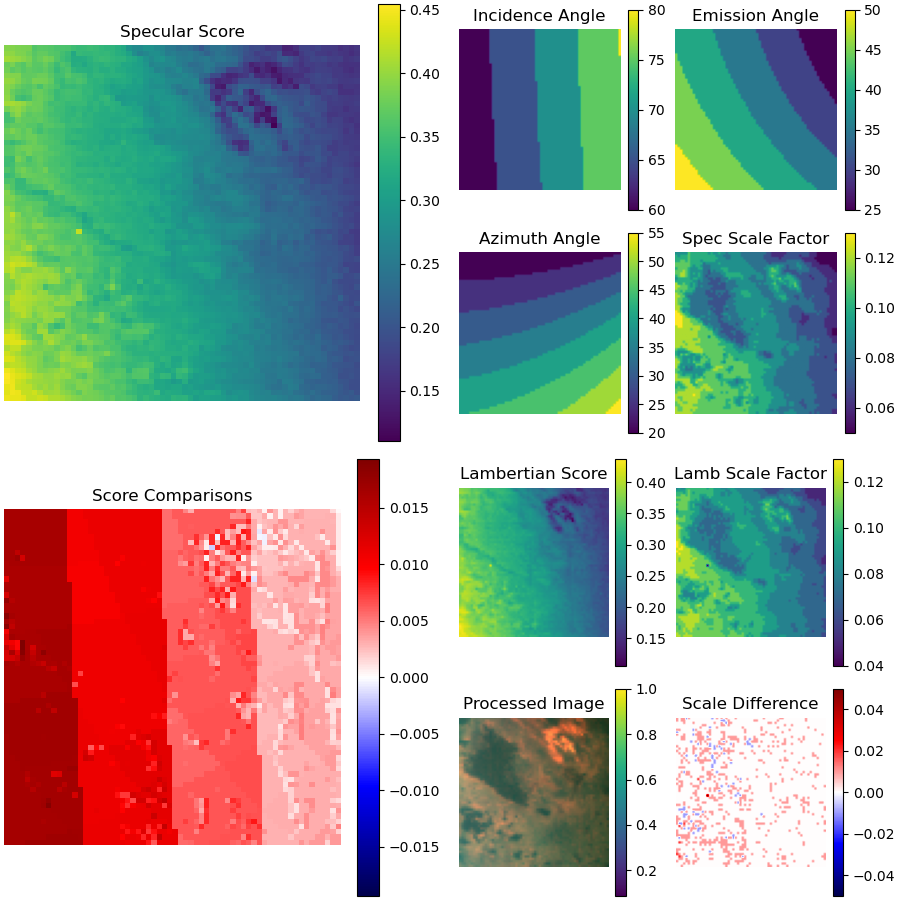

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [165]:
%matplotlib notebook

method = "chi"

# "mul" multiplies everything by a scale factor for testing.
# "add" adds an offset to the data for testing.
# "chi" is a the chi-squared method.

#CREATE IMAGE!
#Goal: two images showcasing how close each pixel is to model. 

fig = plt.figure(figsize = (9,9), layout="constrained")

subfigs = fig.subfigures(2, 2, width_ratios=[1,1])

axA = subfigs[0][0].subplots()
axB = subfigs[1][0].subplots()
axC = subfigs[0][1].subplots(2,2)
axD = subfigs[1][1].subplots(2,2)

#First, the data our final image holds.
modelDiff = np.transpose(temp[0]*0.) #How far we have to shift
modelAcc = np.transpose(temp[0]*0.) #Value of best fit
modelDiffL = np.transpose(temp[0]*0.) #Lambertian versions of the above.
modelAccL = np.transpose(temp[0]*0.) 

angleI = np.transpose(temp[0]*0.)
angleA = np.transpose(temp[0]*0.)
angleE = np.transpose(temp[0]*0.)
#Transposed for a reason. "temp" is in wyx, and yx is not the arrangement we want for the image, we want xy.

#Up next is the bulk of the program, a massive loop that iterates over every single pixel 
#and records the appropriate values.
i,j = 0,0
while (i < len(xAxisCube)):
    j = 0
    while (j < len(yAxisCube)):
        #We have selected a pixel at this point.
        #First, grab the data for all 8 windows. Store it in an array.
        pixelWindows = [0.,0.,0.,0.,0.,0.,0.,0.]
        geomWindows = [0.,0.,0.,0.,0.,0.,0.,0.]
        geomWindowsL = [0.,0.,0.,0.,0.,0.,0.,0.]
        k = 0
        #print(i,j, len(xAxisCube), len(yAxisCube))
        while (k < 8):
            pixelWindows[k] = temp[windowInd[k]][j][i] #Backward since temp itself is in yx.
            k = k+1
        #Now we need to find the geometries for each pixel. Specifically:
        #incidence, emission, azimuth. 
        #These are contained within the geofiles.
        inci = geoIRData[i][j][5]
        emis = geoIRData[i][j][6]
        
        #Azimuth formula from Jason Barnes' phasecurve.c++
        p = geoIRData[i][j][4] #used to calculate azimuth.
        ratio = -(np.cos(np.radians(p)) - np.cos(np.radians(inci))* np.cos(np.radians(emis)))/(np.sin(np.radians(inci))*np.sin(np.radians(emis)))
        azim = np.arccos(ratio)
        #Of course, this might be nan-ing. All the nans need their own values.
        if((math.isnan(azim) == True) and (ratio>0.)):
            azim = 0.
        elif((math.isnan(azim) == True) and (ratio<0.)):
            azim = 0.
        elif((inci==0) and (emis==0)):
            azim = 0.
        elif(math.isnan(azim) == True):
            print("Well you broke it, great. (azimuth is nan, but could not be set to anything else)")
        
        #We are now armed with i, e, and phi(azimuth); in addition to the 8 wavelengths. 
        #Each pixel contains 11 pieces of information. 
        #Now we need to grab the comparison information from the viewing geometries.
        #The viewing geometries are in divisions of five degrees, so first all values need to be rounded.
        inci = round(inci/5)*5
        emis = round(emis/5)*5
        azim = round(np.degrees(azim)/5)*5
        #Sometimes data is corrupted or feeds us nonsense. We can force it to be reasonable. 
        if (inci < 0):
            inci = 0
        elif (inci > 100):
            inci = 100
        if (emis < 0):
            emis = 0
        elif (emis > 90):
            emis = 90
        if (azim < 0):
            azim = 0
        if (azim > 180):
            azim = 180
        
        #print(inci, emis, azim)
        
        geomWindows[0] = dataWin1[int(inci / 5)][int(emis / 5)][int(azim / 5)]
        geomWindows[1] = dataWin2[int(inci / 5)][int(emis / 5)][int(azim / 5)]
        geomWindows[2] = dataWin3[int(inci / 5)][int(emis / 5)][int(azim / 5)]
        geomWindows[3] = dataWin4[int(inci / 5)][int(emis / 5)][int(azim / 5)]
        geomWindows[4] = dataWin5[int(inci / 5)][int(emis / 5)][int(azim / 5)]
        geomWindows[5] = dataWin6[int(inci / 5)][int(emis / 5)][int(azim / 5)]
        geomWindows[6] = dataWin7[int(inci / 5)][int(emis / 5)][int(azim / 5)]
        geomWindows[7] = dataWin8[int(inci / 5)][int(emis / 5)][int(azim / 5)]            
        geomWindowsL[0] = dataWin1L[int(inci / 5)][int(emis / 5)][int(azim / 5)]
        geomWindowsL[1] = dataWin2L[int(inci / 5)][int(emis / 5)][int(azim / 5)]
        geomWindowsL[2] = dataWin3L[int(inci / 5)][int(emis / 5)][int(azim / 5)]
        geomWindowsL[3] = dataWin4L[int(inci / 5)][int(emis / 5)][int(azim / 5)]
        geomWindowsL[4] = dataWin5L[int(inci / 5)][int(emis / 5)][int(azim / 5)]
        geomWindowsL[5] = dataWin6L[int(inci / 5)][int(emis / 5)][int(azim / 5)]
        geomWindowsL[6] = dataWin7L[int(inci / 5)][int(emis / 5)][int(azim / 5)]
        geomWindowsL[7] = dataWin8L[int(inci / 5)][int(emis / 5)][int(azim / 5)]
        #Maybe should have made the viewing geometry data in one array... oh well.
        #Anyway, that's all the data we need. Now comes the actual processing steps!
        #First: determine a scaling factor that will minimize the differences across
        #all eight windows.
        scale = 0 #start at 0, work up to 10. This is decidedly overzealous.
        tempScale = 0 #For adjusting.
        score = 1000 #To determine which is the best. Absurdly large at the start.
        scoreL = 1000 #Lambertian as well.
        scaleL = 0
        
        floorVal = np.amin(geomWindows)  
        floorValL = np.amin(geomWindowsL)
        if (floorValL > floorVal):
            floorVal = floorVal
        #Get the smallest value so we can start at the lowest
        #offset when using the "add" method
        
        if (method == "mul"):
            while (tempScale <= 100):
                tempScore = 0
                tempScoreL = 0
                k = 0
                while (k < 8):
                    tempScore = tempScore + abs(geomWindows[k]*tempScale - pixelWindows[k])
                    tempScoreL = tempScoreL + abs(geomWindowsL[k]*tempScale - pixelWindows[k])
                    #The score is very simple: simply add up the differences in all 8 points.
                    k = k+1
                if (tempScore < score):
                    score = tempScore #Lower score is better!
                    scale = tempScale
                if (tempScoreL < scoreL):
                    scoreL = tempScoreL
                    scaleL = tempScale
                tempScale = tempScale + 1           
        elif (method == "add"):
            while (tempScale <= 1):
                tempScore = 0
                tempScoreL = 0
                k = 0
                while (k < 8):
                    tempScore = tempScore + abs(geomWindows[k]+(tempScale-floorVal) - pixelWindows[k])
                    tempScoreL = tempScoreL + abs(geomWindowsL[k]+(tempScale-floorVal) - pixelWindows[k])
                    #The score is very simple: simply add up the differences in all 8 points.
                    k = k+1
                #if (i == 1 and j == 1):
                    #print(tempScale, tempScore)
                if (tempScore < score):
                    score = tempScore #Lower score is better!
                    scale = tempScale
                if (tempScoreL < scoreL):
                    scoreL = tempScoreL
                    scaleL = tempScale
                tempScale = tempScale + 0.01
        elif(method == "chi"):
            tempScore = 0
            tempScoreL = 0
            k = 0
            while (k < 8):
                tempScore = tempScore + ((pixelWindows[k]-geomWindows[k])*(pixelWindows[k]-geomWindows[k]))/(geomWindows[k])
                tempScoreL = tempScoreL + ((pixelWindows[k]-geomWindowsL[k])*(pixelWindows[k]-geomWindowsL[k]))/(geomWindowsL[k])
                #The score is very simple: simply add up all the chi-squared terms
                k = k+1
            score = tempScore 
            scale = 0
            scoreL = tempScoreL
            scaleL = 0
   
        modelDiff[i][j] = scale
        modelAcc[i][j] = score #Apparently it needs to flip here. 
        angleE[i][j] = emis
        angleI[i][j] = inci
        angleA[i][j] = azim
        
        modelDiffL[i][j] = scaleL
        modelAccL[i][j] = scoreL
        #There were some concerns that index flipping and transpositions might cause an
        #issue, but it appears to be fine either way. 
        #Even when the transpositions are done very badly it still works well enough.
        j=j+1
    i=i+1    

#Now, finally, display everything.

cmap = "viridis"

axA.set(title="Specular Score")
imgA = axA.imshow(modelAcc, cmap = cmap)
fig.colorbar(imgA, ax=axA)
axB.set(title="Score Comparisons")

#For any comparison with a middle, we need to set that middle.
diffDiff = modelDiff - modelDiffL
accDiff = modelAcc - modelAccL
maxi = np.amax(diffDiff)
mini = np.amin(diffDiff)
boundsD = 0
if (maxi > abs(mini)): 
    boundsD = maxi
else: boundsD = abs(mini)
maxi = np.amax(accDiff)
mini = np.amin(accDiff)
boundsA = 0
if (maxi > abs(mini)): 
    boundsA = maxi
else: boundsA = abs(mini)

imgB = axB.imshow(accDiff, cmap = "seismic", vmin = -boundsA, vmax = boundsA)
fig.colorbar(imgB, ax=axB)
axC[0][0].set(title="Incidence Angle")
axC[0][1].set(title="Emission Angle")
axC[1][0].set(title="Azimuth Angle")
axC[1][1].set(title="Spec Scale Factor")
imgC1 = axC[0][0].imshow(angleI, cmap = cmap)
imgC2 = axC[0][1].imshow(angleE, cmap = cmap)
imgC3 = axC[1][0].imshow(angleA, cmap = cmap)
imgC4 = axC[1][1].imshow(modelDiff, cmap = cmap)
fig.colorbar(imgC1, ax=axC[0][0])
fig.colorbar(imgC2, ax=axC[0][1])
fig.colorbar(imgC3, ax=axC[1][0])
fig.colorbar(imgC4, ax=axC[1][1])
axD[0][0].set(title="Lambertian Score")
axD[0][1].set(title="Lamb Scale Factor")
axD[1][0].set(title="Processed Image")
axD[1][1].set(title="Scale Difference")
imgD1 = axD[0][0].imshow(modelAccL, cmap = cmap)
imgD2 = axD[0][1].imshow(modelDiffL, cmap = cmap)
imgD3 = axD[1][0].imshow(ndimage.rotate(colorData,90), cmap = cmap, origin="lower")
imgD4 = axD[1][1].imshow(diffDiff, cmap = "seismic", vmin = -boundsD, vmax = boundsD)
fig.colorbar(imgD1, ax=axD[0][0])
fig.colorbar(imgD2, ax=axD[0][1])
fig.colorbar(imgD3, ax=axD[1][0])
fig.colorbar(imgD4, ax=axD[1][1])


axA.axis('off') #remove border and ticks. 
axC[0][0].axis('off')
axC[0][1].axis('off')
axC[1][0].axis('off')
axC[1][1].axis('off')
axB.axis('off') #remove border and ticks. 
axD[0][0].axis('off')
axD[0][1].axis('off')
axD[1][0].axis('off')
axD[1][1].axis('off')

plt.show()

<IPython.core.display.Javascript object>


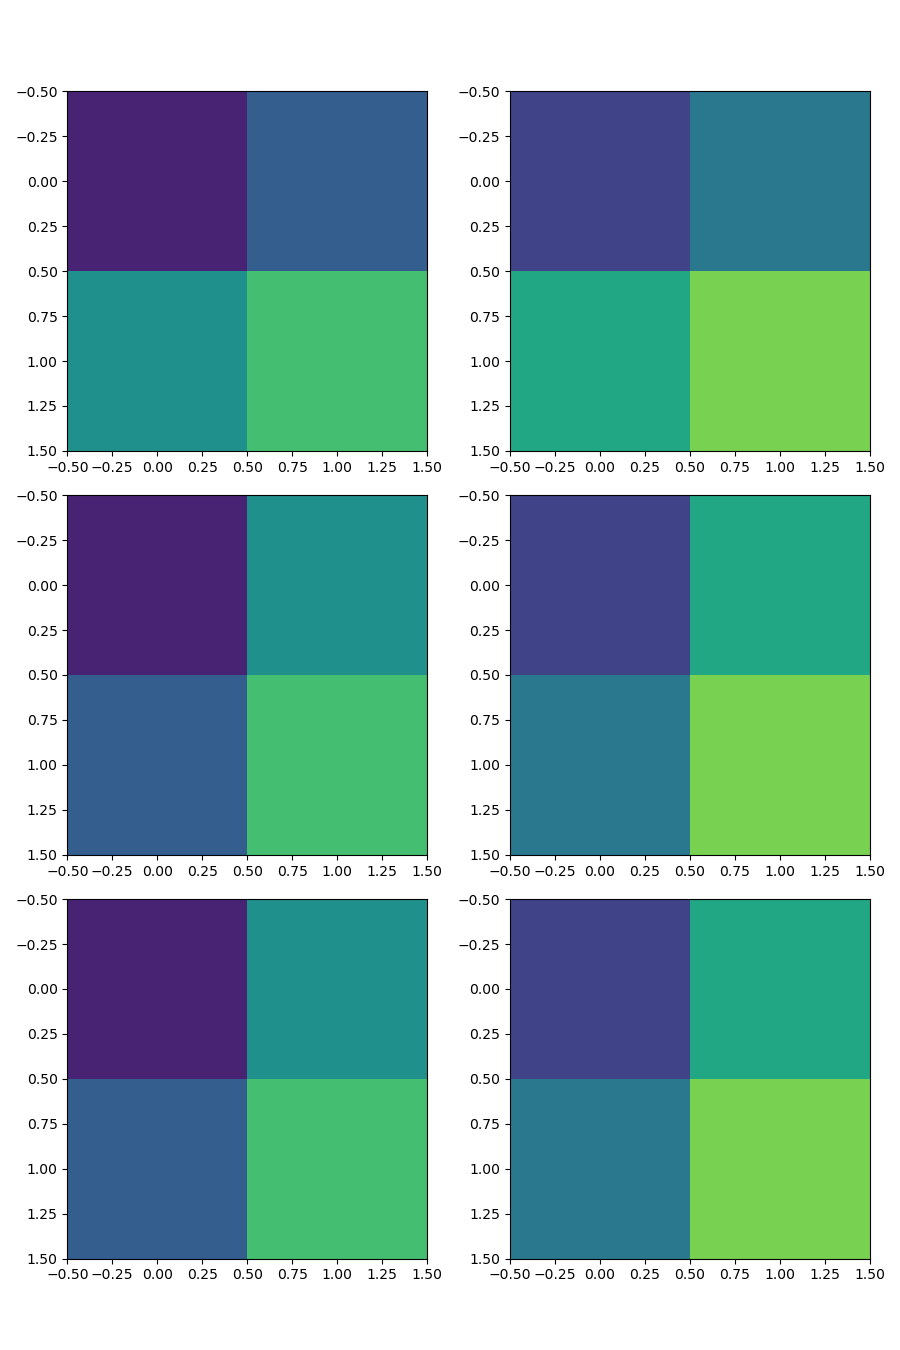

In [5]:
#Tests and Stuff:

matr = [[[0 for x in range(2)] for x in range(2)] for x in range(2)]

i,j,k,t = 0,0,0,0.1
while (i<2):
    j=0
    while (j<2):
        k=0
        while (k<2):
            matr[i][j][k] = t
            t = t+0.1
            k = k+1
        j = j+1
    i = i+1
    
fig, axs = plt.subplots(3,2,figsize = (9,13.5), layout = "tight") 

imgA = [[matr[0][0][0],matr[0][1][0]],[matr[1][0][0],matr[1][1][0]]]
imgB = [[matr[0][0][1],matr[0][1][1]],[matr[1][0][1],matr[1][1][1]]]


axs[0,0].imshow(imgA,vmax = 1,vmin=0)
axs[0,1].imshow(imgB,vmax = 1,vmin=0)
axs[1,0].imshow(np.transpose(matr)[0],vmax = 1,vmin=0)
axs[1,1].imshow(np.transpose(matr)[1],vmax = 1,vmin=0)
axs[2,0].imshow(np.transpose(matr)[0],vmax = 1,vmin=0)
axs[2,1].imshow(np.transpose(matr)[1],vmax = 1,vmin=0)


plt.show()